In [27]:
from utils import find_matching_experiments, parse_sim_results, parse_vllm_results, calculate_errors, plot_results
import os

vllm_dir = "../../inference-sim/largesweep"
sim_dir = "../../inference-sim/results/sweep_params"
baseline_sim_dir = "../../inference-sim/results/baseline"

sweep_configs = {
    'num_prompts': [100, 200, 400, 800, 1600],
    'request_rate': [4,8,16,32,64,128],
    'temperature': [0.0],
    'max_num_batched_tokens': [256, 512, 1024, 2048, 4096, 8192],
    'long_prefill_token_threshold': [16, 32, 64, 128, 256, 512, 1024],
    'datasets': [{'name': 'sharegpt', 'path': 'ShareGPT_V3_unfiltered_cleaned_split.json'}]
}

# sweep_configs = {
            
#         'num_prompts': [200, 400, 1600],
#         'request_rate': [8,16,64,128],
#         'temperature': [0.0],
#         'max_num_batched_tokens': [256, 512], 
#         'long_prefill_token_threshold': [32, 128],
#         'datasets': [{'name': 'sharegpt', 'path': 'ShareGPT_V3_unfiltered_cleaned_split.json'}]
#     }

# graphing parameters
x_axis = 'request_rate'
y_axis = 'num_prompts'
metrics = ['ttft_mean_accuracy', 'ttft_accuracy','tpot_accuracy', 'tpot_mean_accuracy', 'ttft_median_accuracy', 'tpot_median_accuracy', 'ttft_p99_accuracy', 'tpot_p99_accuracy', 'duration_accuracy']
# metrics = ['ttft_accuracy', 'tpot_accuracy', 'ttft_p99_accuracy', 'tpot_p99_accuracy', 'duration_accuracy']
# metrics = ['throughput_accuracy']
single_axis_data = {}
plotting_data = {}
baseline_plotting_data = {}
for metric in metrics:
    plotting_data[metric] = {}
    single_axis_data[metric] = {}
    baseline_plotting_data[metric] = {}
saturation_metric = 'request_rate'  # This is the metric used for saturation analysis
saturation_data = {}
acceleration_data = {}


# Find matching experiments
matching_pairs = find_matching_experiments(sim_dir, vllm_dir, sweep_configs)

print(f"Found {len(matching_pairs)} matching experiment pairs")

# Process each pair
for sim_file, vllm_file, config in matching_pairs:
    print(f"\nProcessing: {os.path.basename(sim_file)}")
    
    # Parse results
    sim_results = parse_sim_results(sim_file)
    baseline_sim_file = os.path.join(baseline_sim_dir, os.path.basename(sim_file))
    if os.path.exists(baseline_sim_file):
        baseline_sim_results = parse_sim_results(baseline_sim_file)
    else:
        print(f"Warning: Baseline simulation file {baseline_sim_file} not found. Skipping baseline results.")
        baseline_sim_results = {}
        
    vllm_results = parse_vllm_results(vllm_file)
    
    # Calculate errors
    errors = calculate_errors(sim_results, vllm_results)
    baseline_errors = calculate_errors(baseline_sim_results, vllm_results)

    if saturation_data.get(str(config[saturation_metric])) is None:
        saturation_data[str(config[saturation_metric])] = []
    saturation_data[str(config[saturation_metric])].append(errors.get('sim_saturation_ratio', None))

    if acceleration_data.get(str(config[saturation_metric])) is None:
        acceleration_data[str(config[saturation_metric])] = []
    acceleration_data[str(config[saturation_metric])].append(vllm_results.get('duration', None) / sim_results.get('sim_duration', 1))

    # Print results
    for metric, value in errors.items():
        if metric in metrics:
            if single_axis_data[metric].get(str(config[y_axis])) is None:
                single_axis_data[metric][str(config[y_axis])] = []

            single_axis_data[metric][str(config[y_axis])].append(value)

            if plotting_data[metric].get(str(config[y_axis])) is None:
                plotting_data[metric][str(config[y_axis])] = {}
            if str(config[x_axis]) not in plotting_data[metric][str(config[y_axis])]:
                plotting_data[metric][str(config[y_axis])][str(config[x_axis])] = []

            if baseline_plotting_data[metric].get(str(config[y_axis])) is None:
                baseline_plotting_data[metric][str(config[y_axis])] = {}
            if str(config[x_axis]) not in baseline_plotting_data[metric][str(config[y_axis])]:
                baseline_plotting_data[metric][str(config[y_axis])][str(config[x_axis])] = []

            
            
            plotting_data[metric][str(config[y_axis])][str(config[x_axis])].append(value)
            baseline_plotting_data[metric][str(config[y_axis])][str(config[x_axis])].append(baseline_errors.get(metric, None))


Found 1150 matching experiment pairs

Processing: exp_100p_4r_0.0t_256mbt_16lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_256mbt_32lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_256mbt_64lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_256mbt_128lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_256mbt_256lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_512mbt_16lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_512mbt_32lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_512mbt_64lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_512mbt_128lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_512mbt_256lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_512mbt_512lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_1024mbt_16lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_1024mbt_32lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_1024mbt_64lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_1024mbt_128lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_1024mbt_256lpt_sharegpt.txt

Processing: exp_100p_4r_0.0t_1024mbt_512lpt_sharegpt.t

In [10]:
import matplotlib.pyplot as plt

x = [int(k) for k in acceleration_data.keys()]
y = [float(v) for v in acceleration_data.values()]

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(x, y, marker='o', linestyle='-', color='#0072B2', linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2)
plt.axhline(0.75, color='red', linestyle='--', linewidth=2, label='y=0.75')
plt.xlabel('Request Rate', fontsize=14, fontweight='bold')
plt.ylabel('Request throughput / Arrival Rate', fontsize=14, fontweight='bold')
plt.title('Throughput Ratio over Request Rate', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.ylim(0, 1.05)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
for xi, yi in zip(x, y):
    plt.text(xi, yi + 0.03, f'{yi:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold', color='#0072B2')
plt.legend()
plt.show()

TypeError: float() argument must be a string or a number, not 'list'

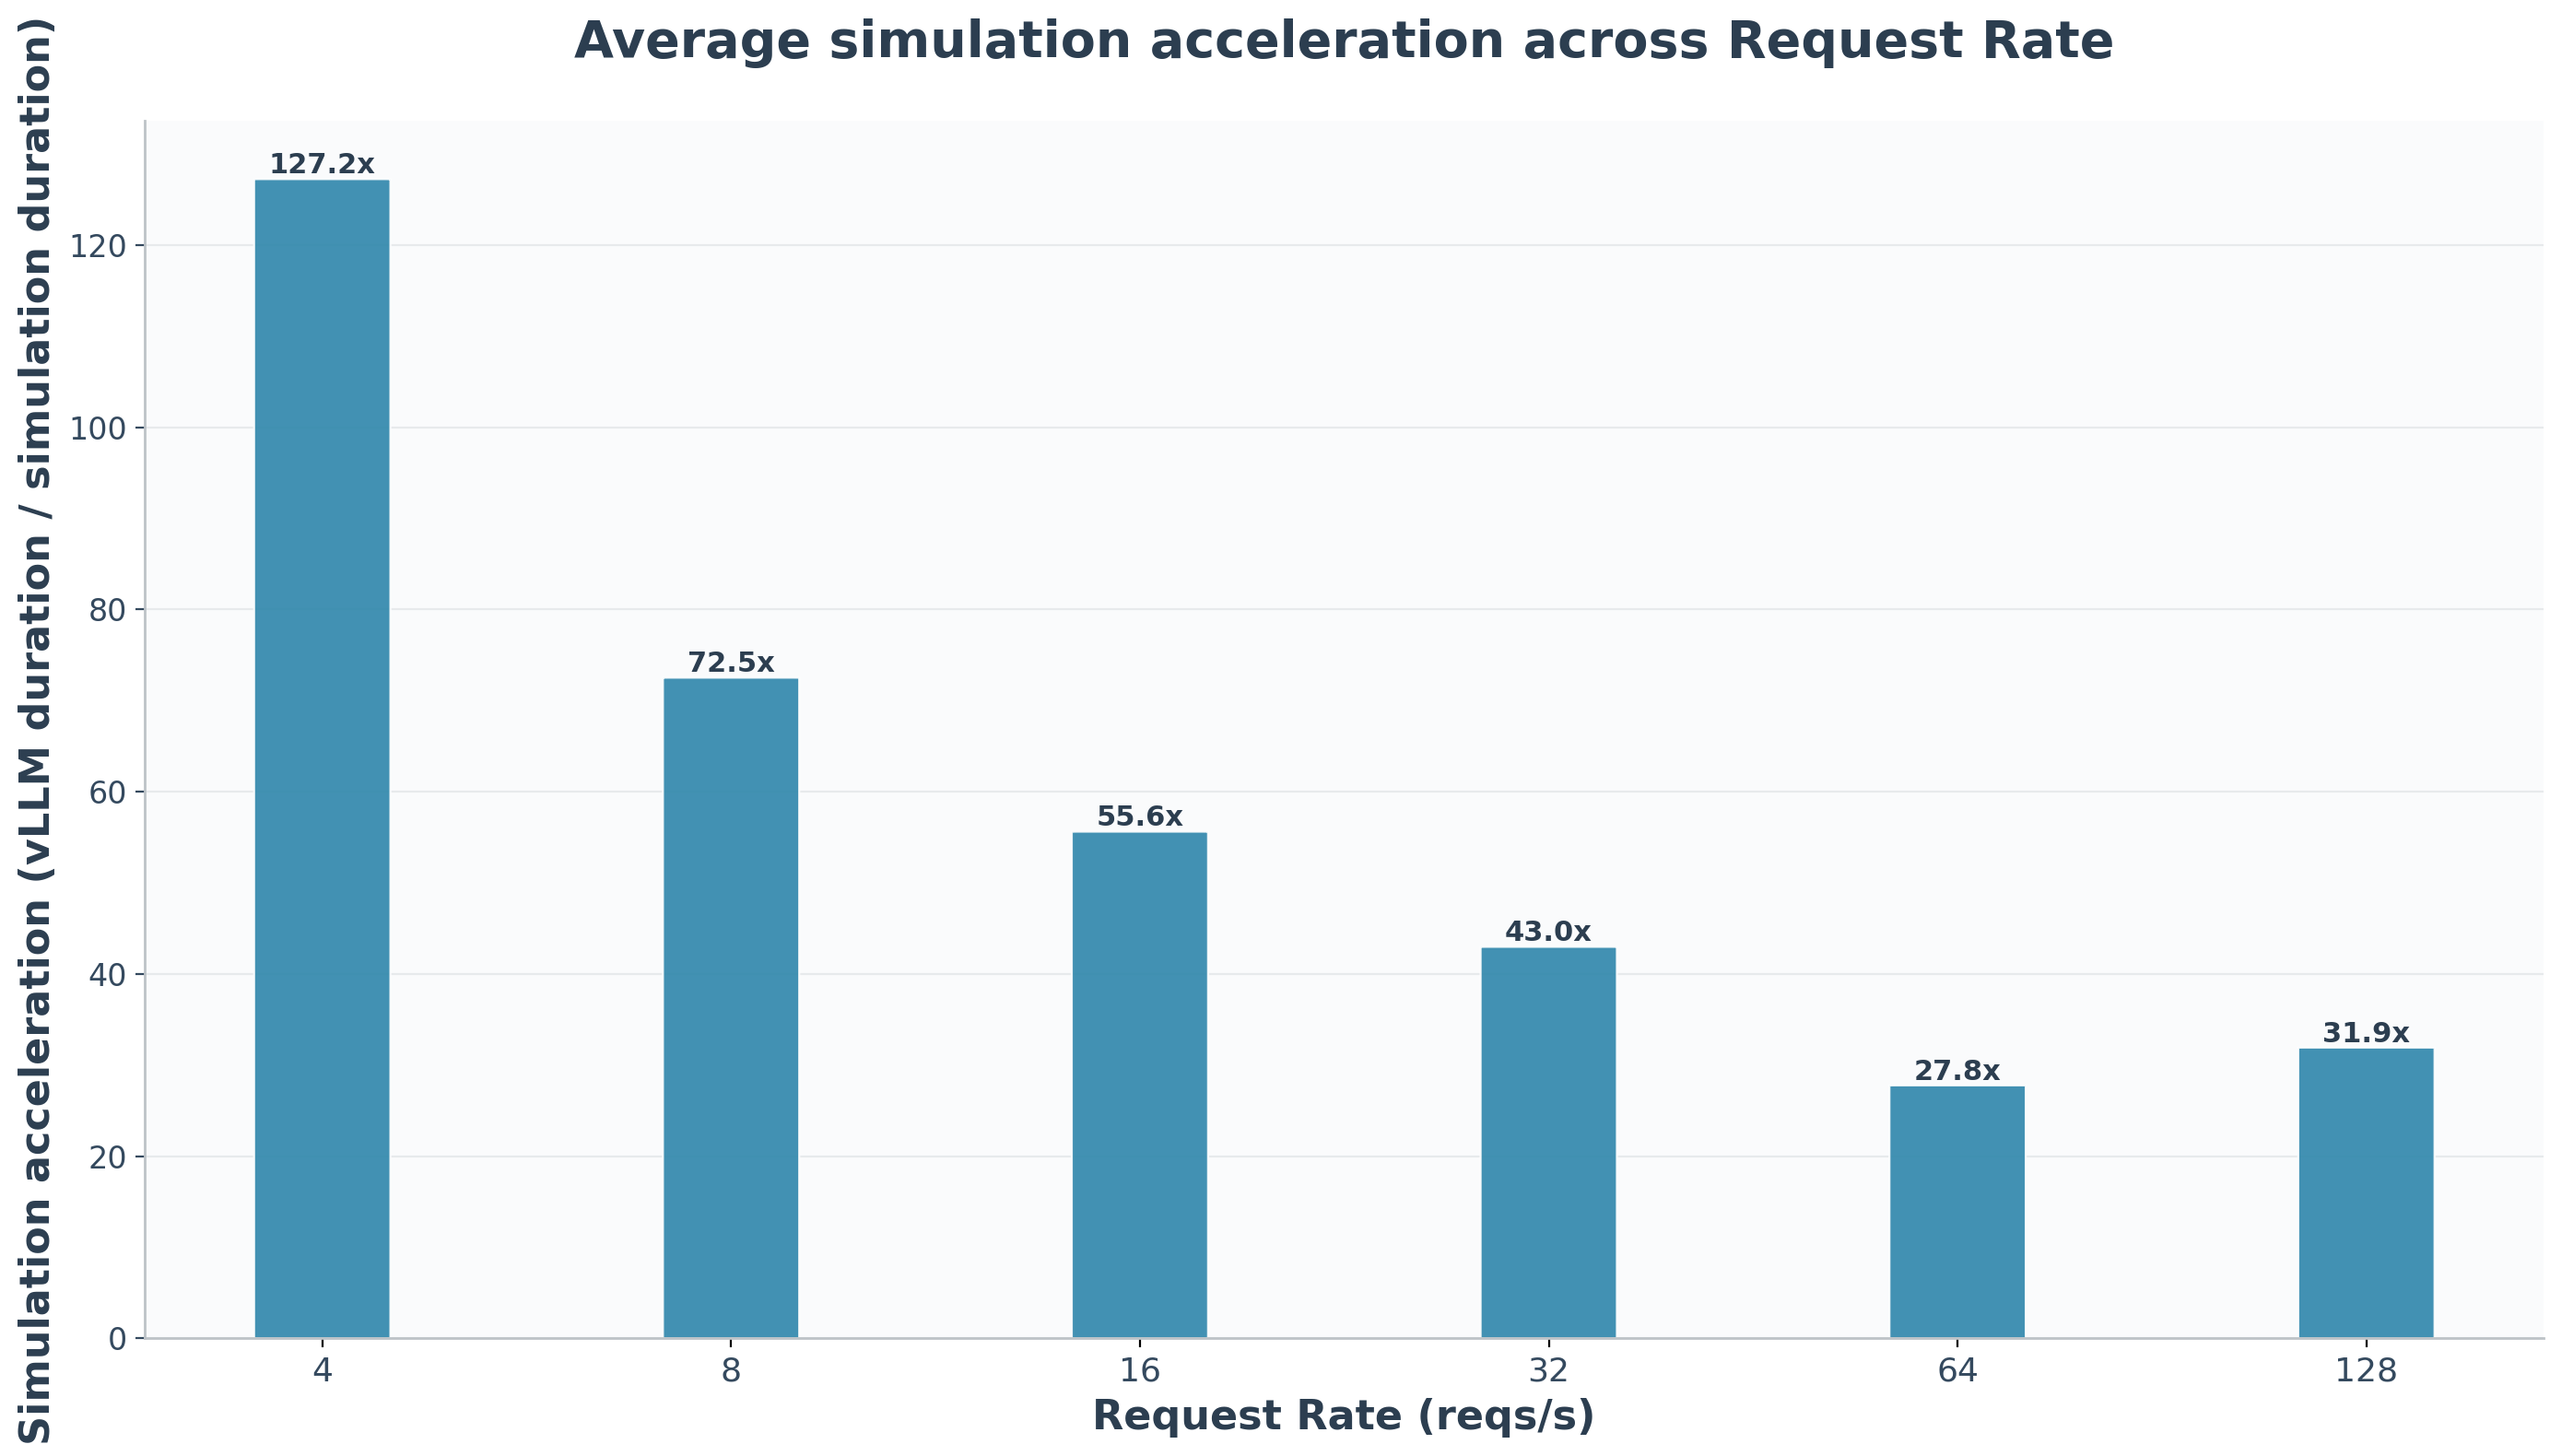

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Data preparation
acceleration_data = {k: np.mean(np.array(v)) for k, v in acceleration_data.items() if v}
x = [int(k) for k in acceleration_data.keys()]
y = [float(v) for v in acceleration_data.values()]

# Professional color
color = '#2E86AB'  # Deep blue

# Set up the plot with modern styling
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 8), dpi=200)

# Position and spacing
x_pos = np.arange(len(x)) * 1.5  # More space between groups
width = 0.5  # Single bar width

# Create bars
bars = ax.bar(x_pos, y, width, 
              color=color, 
              edgecolor='white', linewidth=0.8,
              alpha=0.9)

# Apply rounded corners to bars
def round_bar_corners(bars, radius=0.02):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            # Remove the original bar
            bar.set_visible(False)
            # Create a rounded rectangle
            x_coord = bar.get_x()
            y_coord = bar.get_y()
            w = bar.get_width()
            h = bar.get_height()
            
            # Create rounded rectangle patch
            rounded_rect = mpatches.FancyBboxPatch(
                (x_coord, y_coord), w, h,
                boxstyle=f"round,pad=0,rounding_size={radius}",
                facecolor=bar.get_facecolor(),
                edgecolor=bar.get_edgecolor(),
                linewidth=bar.get_linewidth(),
                alpha=bar.get_alpha()
            )
            ax.add_patch(rounded_rect)

# Apply rounded corners
round_bar_corners(bars)

# Styling
ax.set_xlabel('Request Rate (reqs/s)', fontsize=16, fontweight='bold', 
              color='#2C3E50', fontfamily='sans-serif')
ax.set_ylabel('Simulation acceleration (vLLM duration / simulation duration)', fontsize=16, fontweight='bold', 
              color='#2C3E50', fontfamily='sans-serif')
ax.set_title('Average simulation acceleration across Request Rate', 
             fontsize=20, fontweight='bold', color='#2C3E50', 
             fontfamily='sans-serif', pad=25)

# Customize ticks
ax.set_xticks(x_pos)
ax.set_xticklabels(x, fontsize=13, fontweight='500', 
                   color='#34495E', fontfamily='sans-serif')
ax.tick_params(axis='y', labelsize=12, colors='#34495E')

# Grid styling
ax.grid(axis='y', linestyle='-', alpha=0.3, color='#BDC3C7', linewidth=0.8)
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set background color
ax.set_facecolor('#FAFBFC')
fig.patch.set_facecolor('white')

# Add value labels on bars
def add_value_labels(bars, values):
    for bar, value in zip(bars, values):
        if value > 0:
            height = bar.get_height() if bar.get_visible() else value
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.1f}x', ha='center', va='bottom',
                   fontsize=11, fontweight='bold', color='#2C3E50')

# Add value labels
add_value_labels(bars, y)

plt.tight_layout()
plt.show()

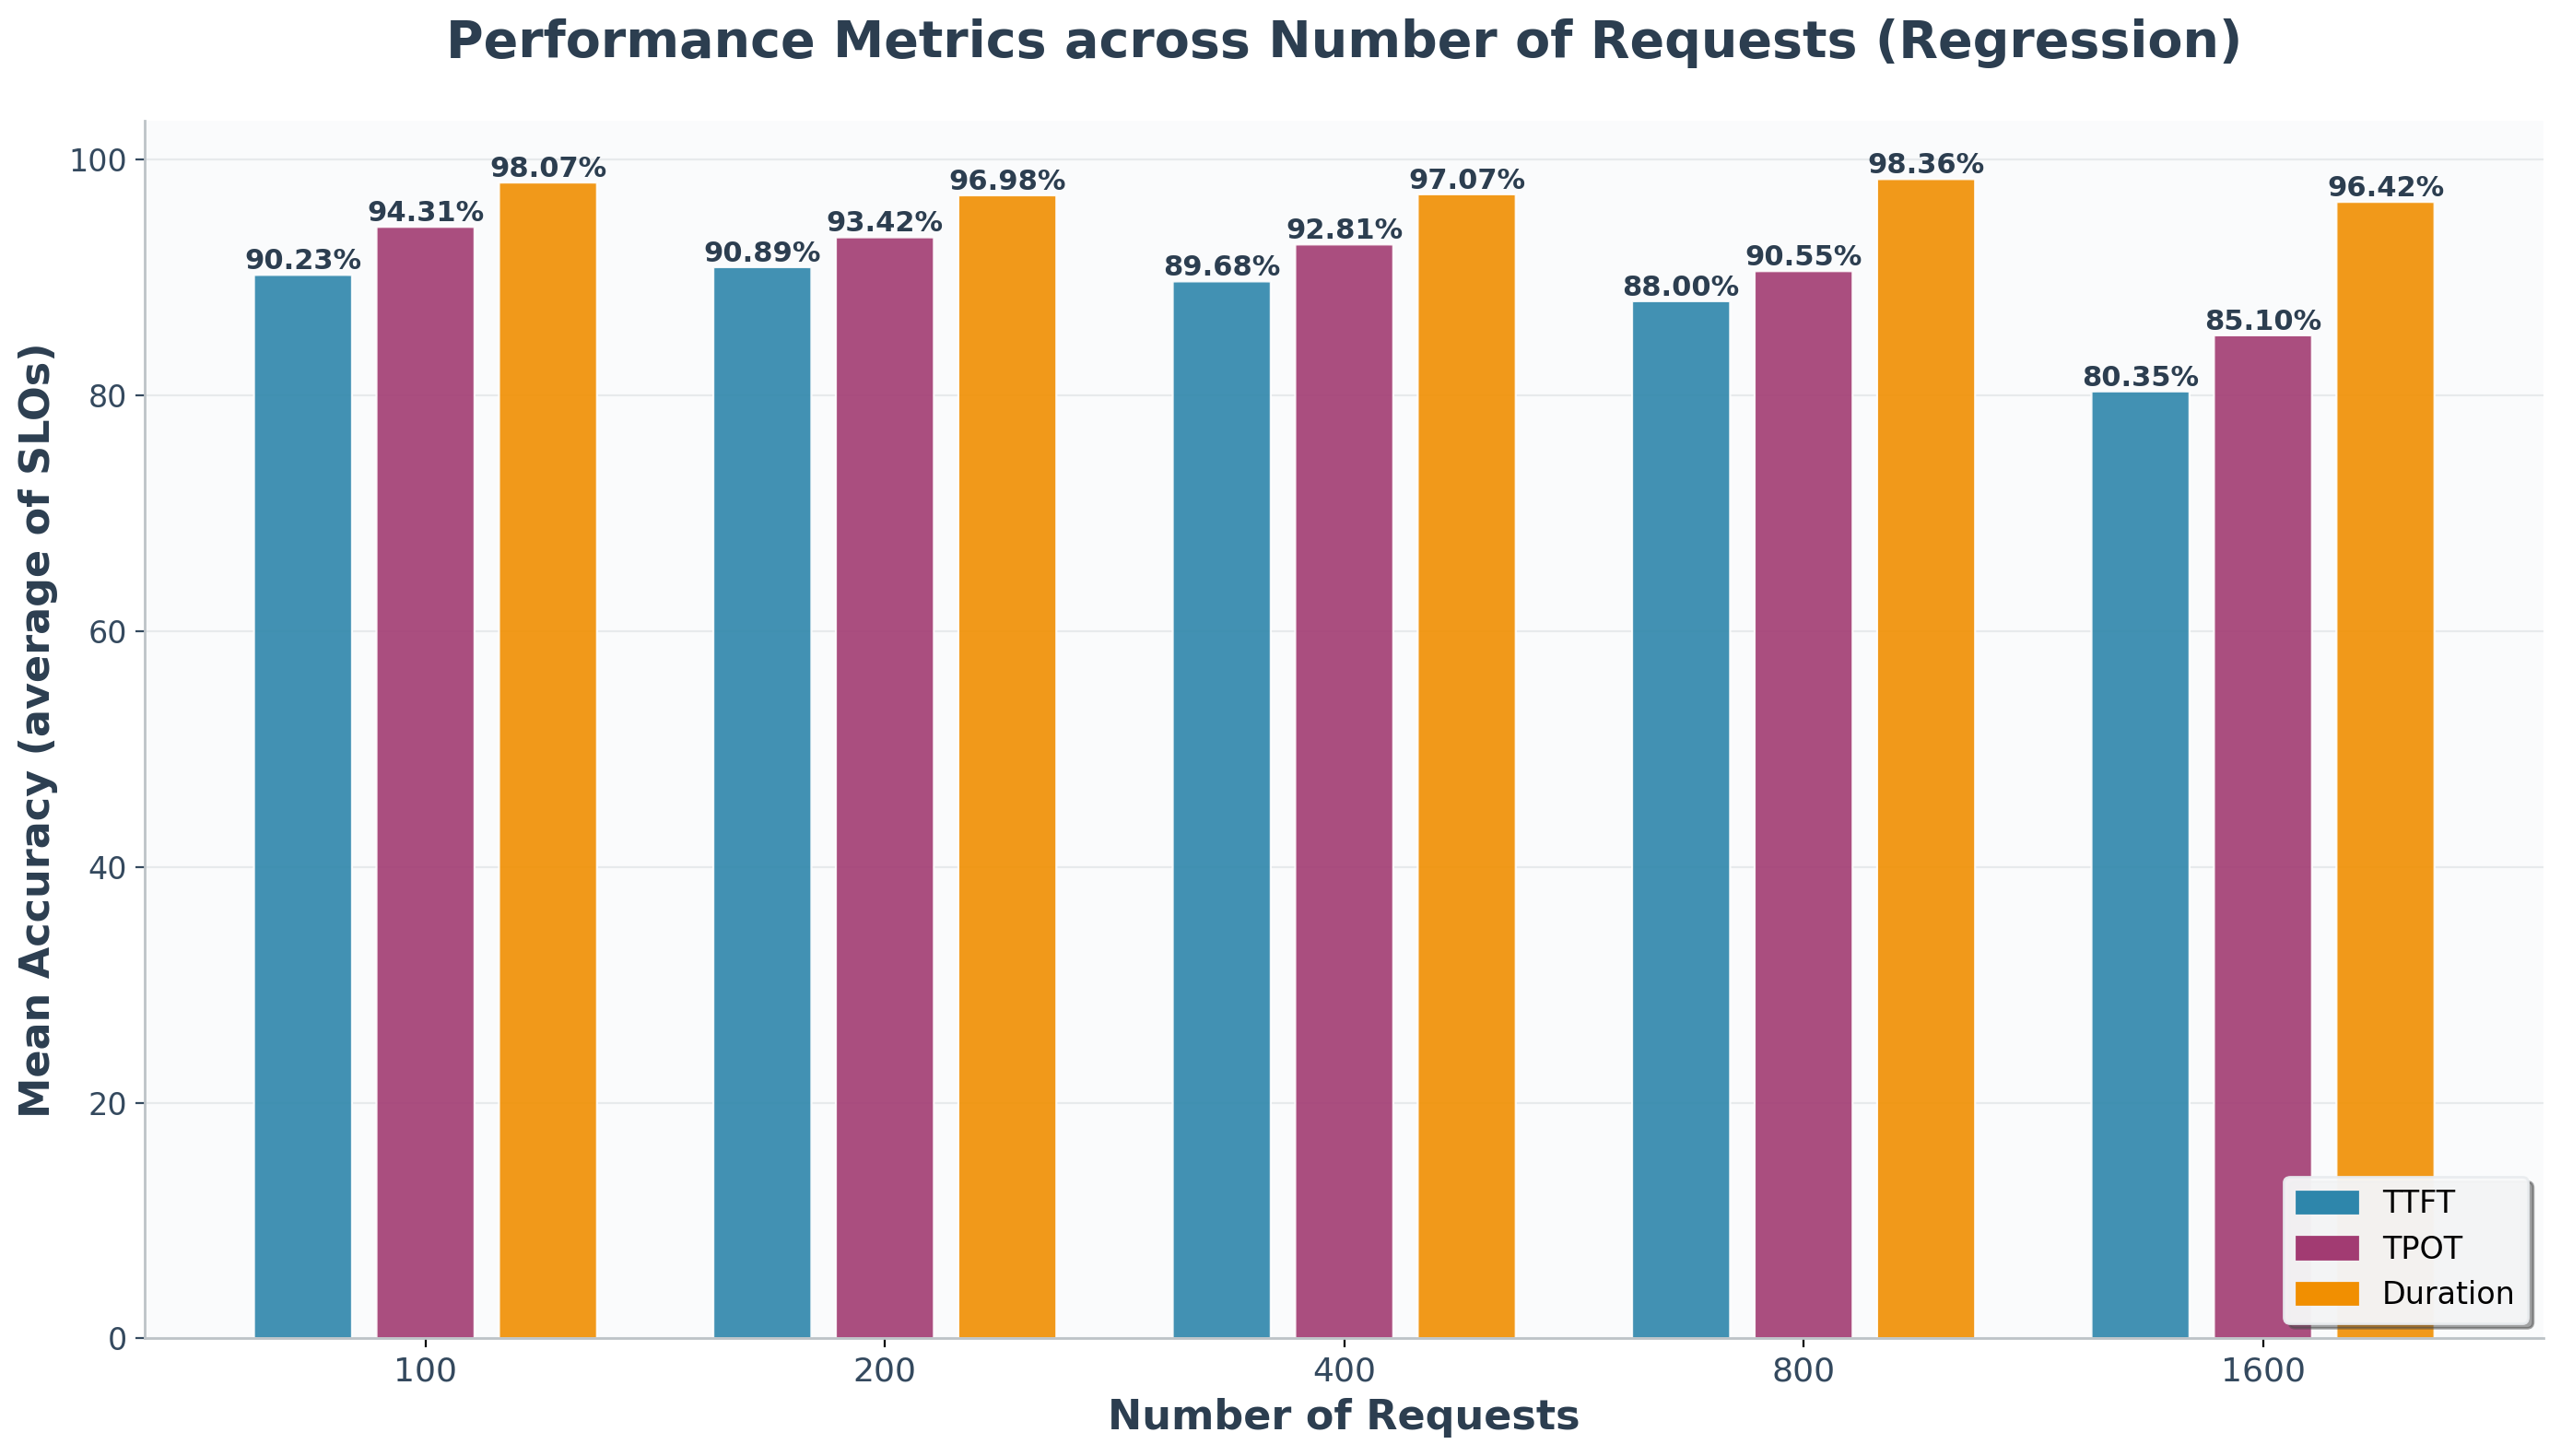

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

def plot_single_axis_data(single_axis_data, x_axis, y_axis):
    x_labels = sorted(sweep_configs[y_axis])
    
    # Prepare data for plotting
    ttft_means = []
    tpot_means = []
    duration_means = []
    
    for x in x_labels:
        ttft_values = [np.mean(single_axis_data['ttft_mean_accuracy'][str(x)]) if str(x) in single_axis_data['ttft_mean_accuracy'] else 0,
                       np.mean(single_axis_data['ttft_accuracy'][str(x)]) if str(x) in single_axis_data['ttft_accuracy'] else 0,
                       np.mean(single_axis_data['ttft_p99_accuracy'][str(x)]) if str(x) in single_axis_data['ttft_p99_accuracy'] else 0]
        tpot_values = [np.mean(single_axis_data['tpot_mean_accuracy'][str(x)]) if str(x) in single_axis_data['tpot_mean_accuracy'] else 0,
                       np.mean(single_axis_data['tpot_accuracy'][str(x)]) if str(x) in single_axis_data['tpot_accuracy'] else 0,
                       np.mean(single_axis_data['tpot_p99_accuracy'][str(x)]) if str(x) in single_axis_data['tpot_p99_accuracy'] else 0]
        duration_value = np.mean(single_axis_data['duration_accuracy'][str(x)]) if str(x) in single_axis_data['duration_accuracy'] else 0
        
        ttft_means.append(np.mean(ttft_values))
        tpot_means.append(np.mean(tpot_values))
        duration_means.append(duration_value)
    
    # Professional color palette
    colors = {
        'ttft': '#2E86AB',      # Deep blue
        'tpot': '#A23B72',      # Deep magenta
        'duration': '#F18F01'   # Warm orange
    }
    
    # Set up the plot with modern styling
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 8), dpi=200)
    
    # Position and spacing
    x_pos = np.arange(len(x_labels)) * 1.5  # More space between groups
    width = 0.32  # Narrower bars for better spacing
    spacing = 0.08  # Larger gap between bars in same group
    
    # Create bars with rounded corners
    bars1 = ax.bar(x_pos - width - spacing, ttft_means, width, 
                   label='TTFT', color=colors['ttft'], 
                   edgecolor='white', linewidth=0.8,
                   alpha=0.9)
    bars2 = ax.bar(x_pos, tpot_means, width, 
                   label='TPOT', color=colors['tpot'], 
                   edgecolor='white', linewidth=0.8,
                   alpha=0.9)
    bars3 = ax.bar(x_pos + width + spacing, duration_means, width, 
                   label='Duration', color=colors['duration'], 
                   edgecolor='white', linewidth=0.8,
                   alpha=0.9)
    
    # Apply rounded corners to bars
    def round_bar_corners(bars, radius=0.02):
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                # Remove the original bar
                bar.set_visible(False)
                # Create a rounded rectangle
                x = bar.get_x()
                y = bar.get_y()
                w = bar.get_width()
                h = bar.get_height()
                
                # Create rounded rectangle patch
                rounded_rect = mpatches.FancyBboxPatch(
                    (x, y), w, h,
                    boxstyle=f"round,pad=0,rounding_size={radius}",
                    facecolor=bar.get_facecolor(),
                    edgecolor=bar.get_edgecolor(),
                    linewidth=bar.get_linewidth(),
                    alpha=bar.get_alpha()
                )
                ax.add_patch(rounded_rect)
    
    # Apply rounded corners
    round_bar_corners(bars1)
    round_bar_corners(bars2)
    round_bar_corners(bars3)
    
    # Styling
    ax.set_xlabel('Number of Requests', fontsize=16, fontweight='bold', 
                  color='#2C3E50', fontfamily='sans-serif')
    ax.set_ylabel('Mean Accuracy (average of SLOs)', fontsize=16, fontweight='bold', 
                  color='#2C3E50', fontfamily='sans-serif')
    ax.set_title('Performance Metrics across Number of Requests (Regression)', 
                 fontsize=20, fontweight='bold', color='#2C3E50', 
                 fontfamily='sans-serif', pad=25)
    
    # Customize ticks
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, fontsize=13, fontweight='500', 
                       color='#34495E', fontfamily='sans-serif')
    ax.tick_params(axis='y', labelsize=12, colors='#34495E')
    
    # Professional legend with proper color patches
    legend_elements = [
        mpatches.Patch(color=colors['ttft'], label='TTFT'),
        mpatches.Patch(color=colors['tpot'], label='TPOT'),
        mpatches.Patch(color=colors['duration'], label='Duration')
    ]
    legend = ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
                      fancybox=True, shadow=True, fontsize=12, framealpha=0.95)
    legend.get_frame().set_facecolor('#F8F9FA')
    legend.get_frame().set_edgecolor('#E9ECEF')
    legend.get_frame().set_linewidth(1)
    
    # Grid styling
    ax.grid(axis='y', linestyle='-', alpha=0.3, color='#BDC3C7', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#BDC3C7')
    ax.spines['bottom'].set_color('#BDC3C7')
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # Set background color
    ax.set_facecolor('#FAFBFC')
    fig.patch.set_facecolor('white')
    
    # Add value labels on bars
    def add_value_labels(bars, values):
        for bar, value in zip(bars, values):
            if value > 0:
                height = bar.get_height() if bar.get_visible() else value
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.2f}%', ha='center', va='bottom',
                       fontsize=11, fontweight='bold', color='#2C3E50')
    
    # Add value labels
    add_value_labels(bars1, ttft_means)
    add_value_labels(bars2, tpot_means)
    add_value_labels(bars3, duration_means)
    
    plt.tight_layout()
    plt.show()

plot_single_axis_data(single_axis_data, x_axis, y_axis)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def calculate_averages(plotting_data):
    """Calculate averages for each metric, y_axis, x_axis combination"""
    averaged_data = {}
    
    for metric in plotting_data:
        averaged_data[metric] = {}
        for y_val in plotting_data[metric]:
            averaged_data[metric][y_val] = {}
            for x_val in plotting_data[metric][y_val]:
                values = plotting_data[metric][y_val][x_val]
                averaged_data[metric][y_val][x_val] = np.mean(values)
    
    return averaged_data

def create_grouped_bar_chart(averaged_data, metric, x_axis_values, y_axis_values, baseline_averaged_data=None):
    """Create a grouped bar chart for a specific metric"""
    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Convert string values to integers for proper sorting
    x_vals = sorted([int(x) for x in x_axis_values])
    y_vals = sorted([int(y) for y in y_axis_values])
    
    # Number of groups (y_axis values) and bars per group (x_axis values)
    n_groups = len(y_vals)
    n_bars_per_group = len(x_vals)
    
    # If baseline data is provided, we need to account for doubled bars
    has_baseline = baseline_averaged_data is not None
    bars_per_x_val = 2 if has_baseline else 1
    total_bars = n_bars_per_group * bars_per_x_val
    
    # Set the width of bars and positions
    bar_width = 0.8 / total_bars
    group_positions = np.arange(n_groups)
    
    # Colors for different x_axis values
    colors = plt.cm.Set3(np.linspace(0, 1, n_bars_per_group))
    
    # Create bars for each x_axis value
    for i, x_val in enumerate(x_vals):
        # Get main data values
        values = []
        for y_val in y_vals:
            y_str = str(y_val)
            x_str = str(x_val)
            if y_str in averaged_data[metric] and x_str in averaged_data[metric][y_str]:
                values.append(averaged_data[metric][y_str][x_str])
            else:
                values.append(0)  # Default value if data is missing
        
        # Calculate position for main bars
        main_positions = group_positions + (i * bars_per_x_val) * bar_width - (total_bars - 1) * bar_width / 2
        
        # Create main bars
        bars = ax.bar(main_positions, values, bar_width, 
                     label=f'{x_axis}={x_val}', color=colors[i], alpha=0.8)
        
        # Add value labels on top of main bars
        for bar, value in zip(bars, values):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{value:.1f}', ha='center', va='bottom', fontsize=8)
        
        # If baseline data is provided, create baseline bars
        if has_baseline:
            baseline_values = []
            for y_val in y_vals:
                y_str = str(y_val)
                x_str = str(x_val)
                if (metric in baseline_averaged_data and 
                    y_str in baseline_averaged_data[metric] and 
                    x_str in baseline_averaged_data[metric][y_str]):
                    baseline_values.append(baseline_averaged_data[metric][y_str][x_str])
                else:
                    baseline_values.append(0)  # Default value if data is missing
            
            # Calculate position for baseline bars (next to main bars)
            baseline_positions = main_positions + bar_width
            
            # Create baseline bars with hatching pattern and lighter color
            baseline_bars = ax.bar(baseline_positions, baseline_values, bar_width, 
                                 label=f'{x_axis}={x_val} (baseline)', 
                                 color=colors[i], alpha=0.5, hatch='///')
            
            # Add value labels on top of baseline bars
            for bar, value in zip(baseline_bars, baseline_values):
                if value > 0:
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    ax.set_xlabel(f'{y_axis.replace("_", " ").title()}', fontsize=12)
    ax.set_ylabel(f'{metric.replace("_", " ").title()}', fontsize=12)
    
    title_suffix = " (with Baseline Comparison)" if has_baseline else ""
    ax.set_title(f'{metric.replace("_", " ").title()} by {y_axis.replace("_", " ").title()} and {x_axis.replace("_", " ").title()}{title_suffix}', 
                fontsize=14, fontweight='bold')
    
    # Set x-axis labels
    ax.set_xticks(group_positions)
    ax.set_xticklabels([f'{y_val}' for y_val in y_vals])
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    return fig

def plot_all_metrics(plotting_data, sweep_configs, x_axis, y_axis, baseline_plotting_data=None):
    """Create plots for all metrics"""
    # Calculate averages
    averaged_data = calculate_averages(plotting_data)
    
    # Calculate baseline averages if provided
    baseline_averaged_data = None
    if baseline_plotting_data is not None:
        baseline_averaged_data = calculate_averages(baseline_plotting_data)
    
    # Get unique values for x and y axes
    x_axis_values = [str(x) for x in sweep_configs[x_axis]]
    
    # Get y_axis values from the data (in case not all values are present)
    y_axis_values = set()
    for metric in averaged_data:
        y_axis_values.update(averaged_data[metric].keys())
    
    # Also include y_axis values from baseline data if available
    if baseline_averaged_data:
        for metric in baseline_averaged_data:
            y_axis_values.update(baseline_averaged_data[metric].keys())
    
    y_axis_values = sorted(list(y_axis_values), key=int)
    
    # Create a plot for each metric
    for metric in averaged_data:
        if averaged_data[metric]:  # Only plot if data exists
            fig = create_grouped_bar_chart(averaged_data, metric, x_axis_values, y_axis_values, baseline_averaged_data)
            
            # Save the plot with appropriate filename
            filename_suffix = "_with_baseline" if baseline_plotting_data is not None else ""
            plt.savefig(f'{metric}_grouped_bar_chart{filename_suffix}.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    return averaged_data

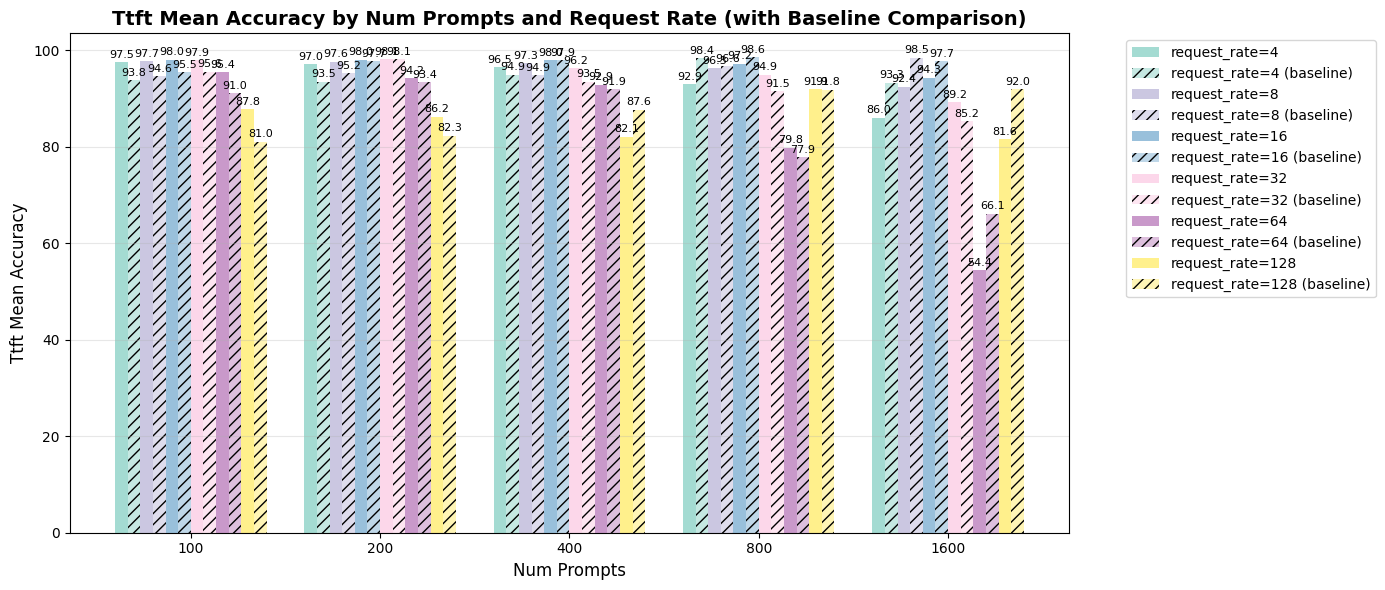

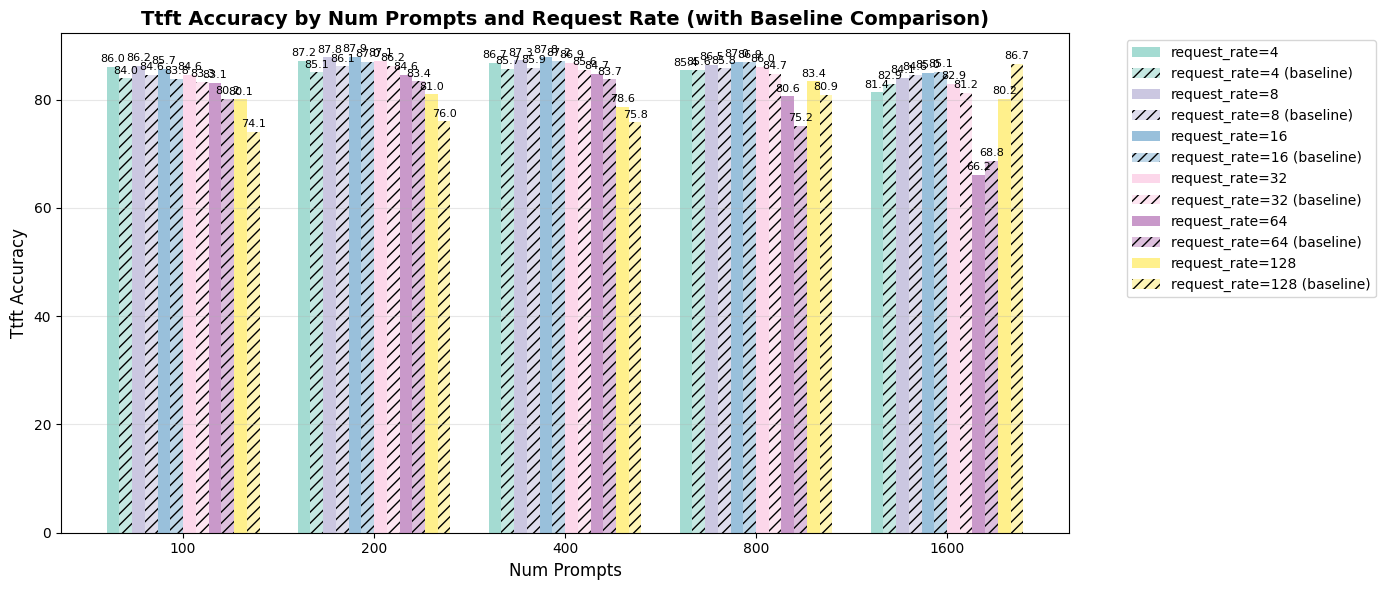

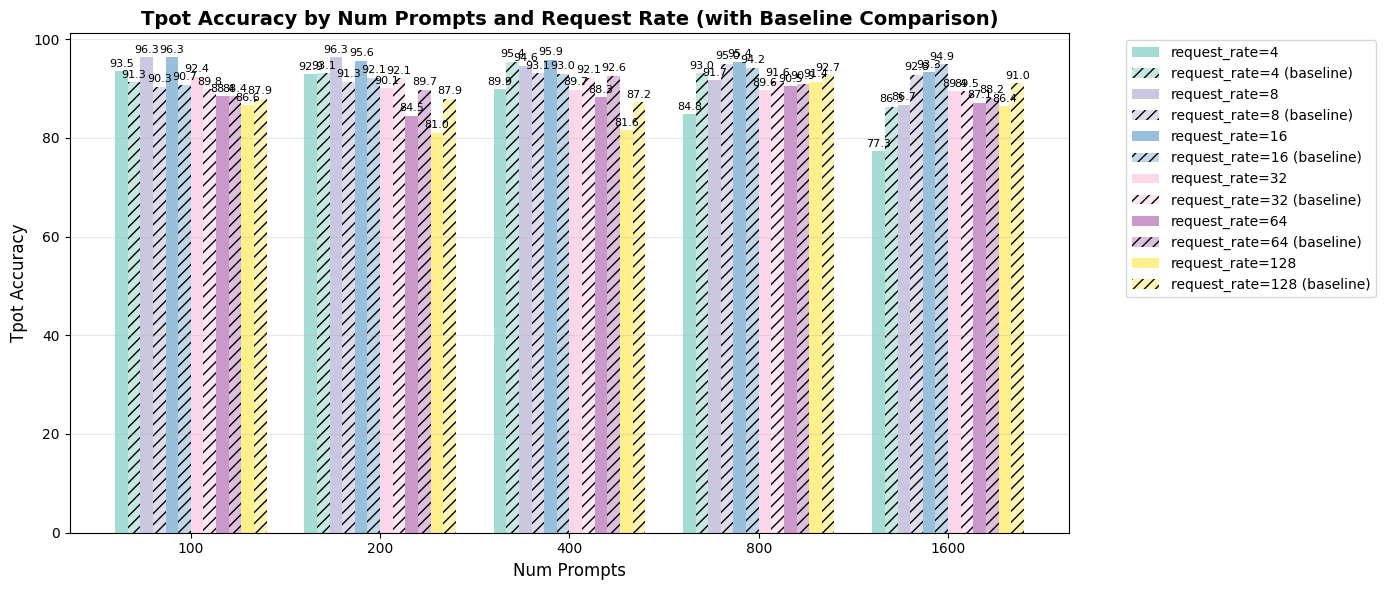

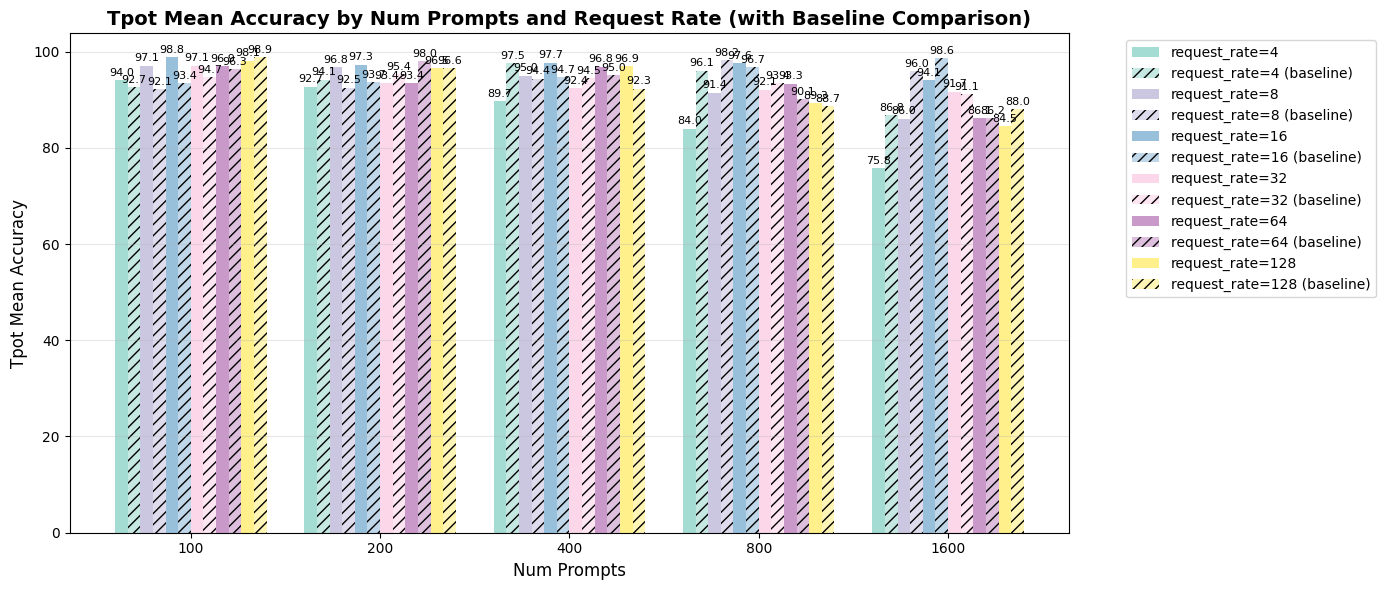

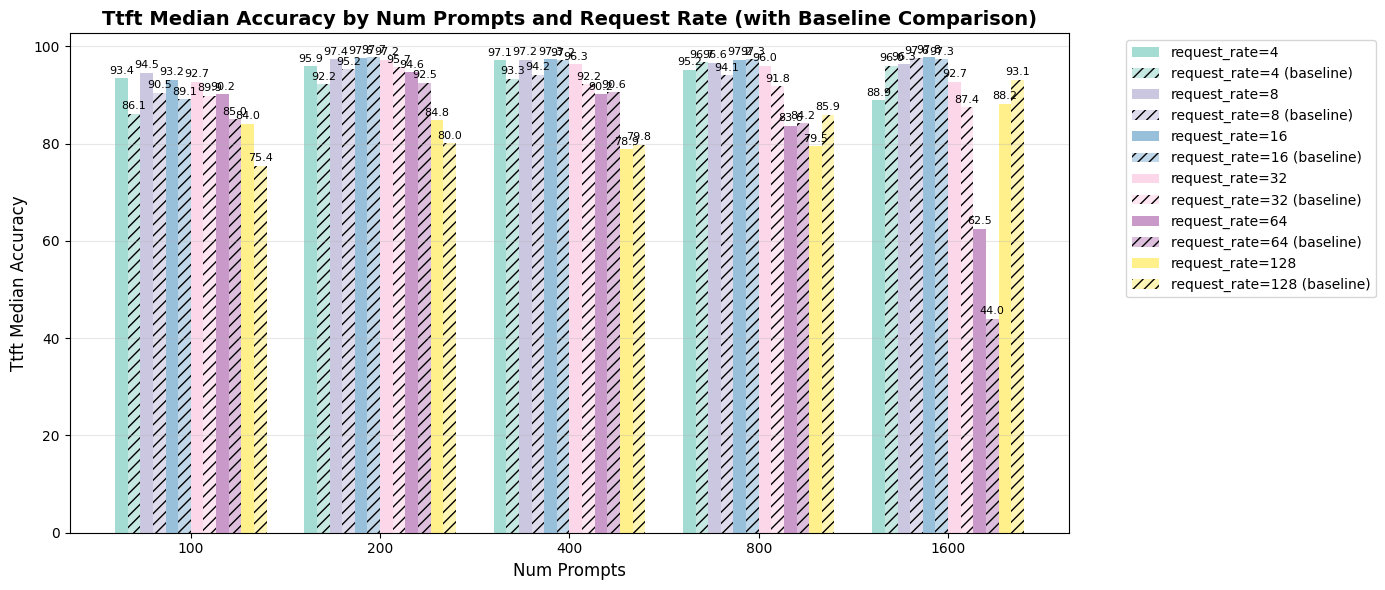

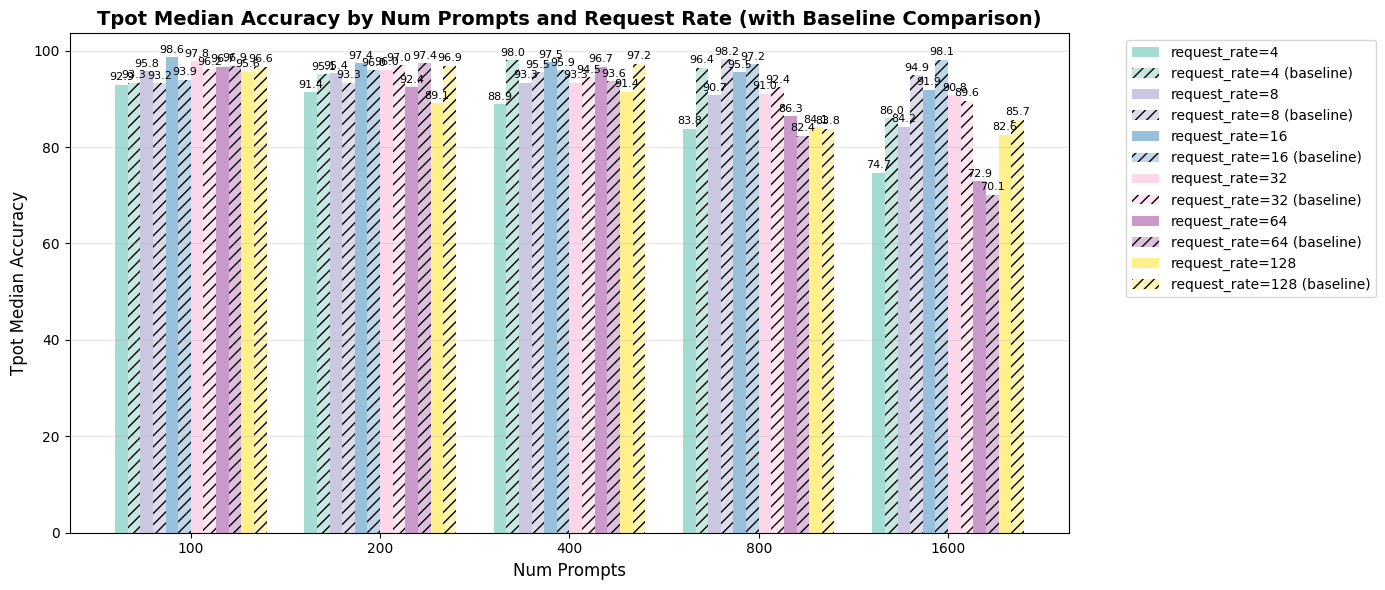

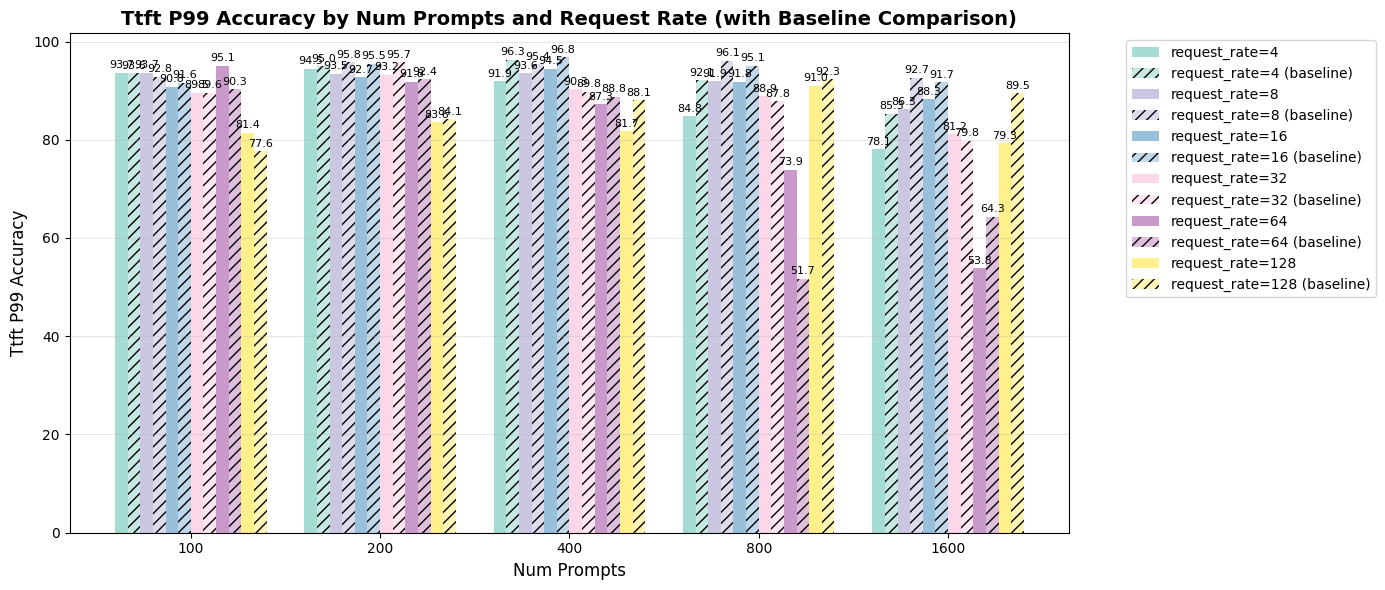

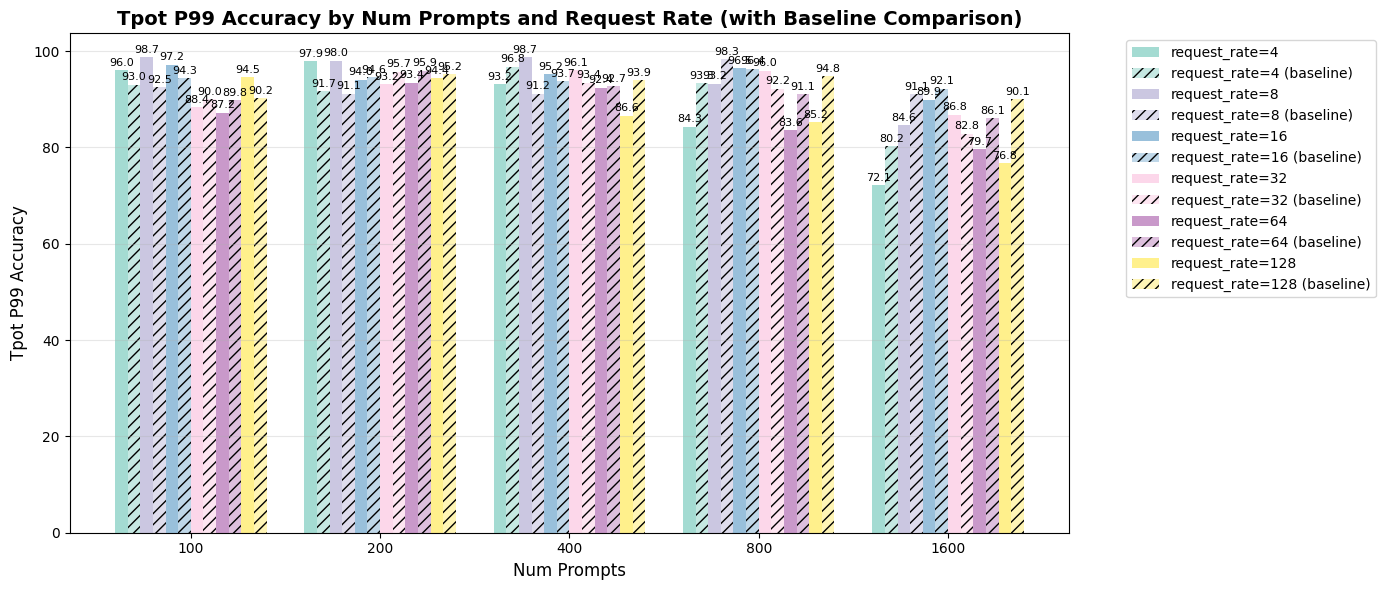

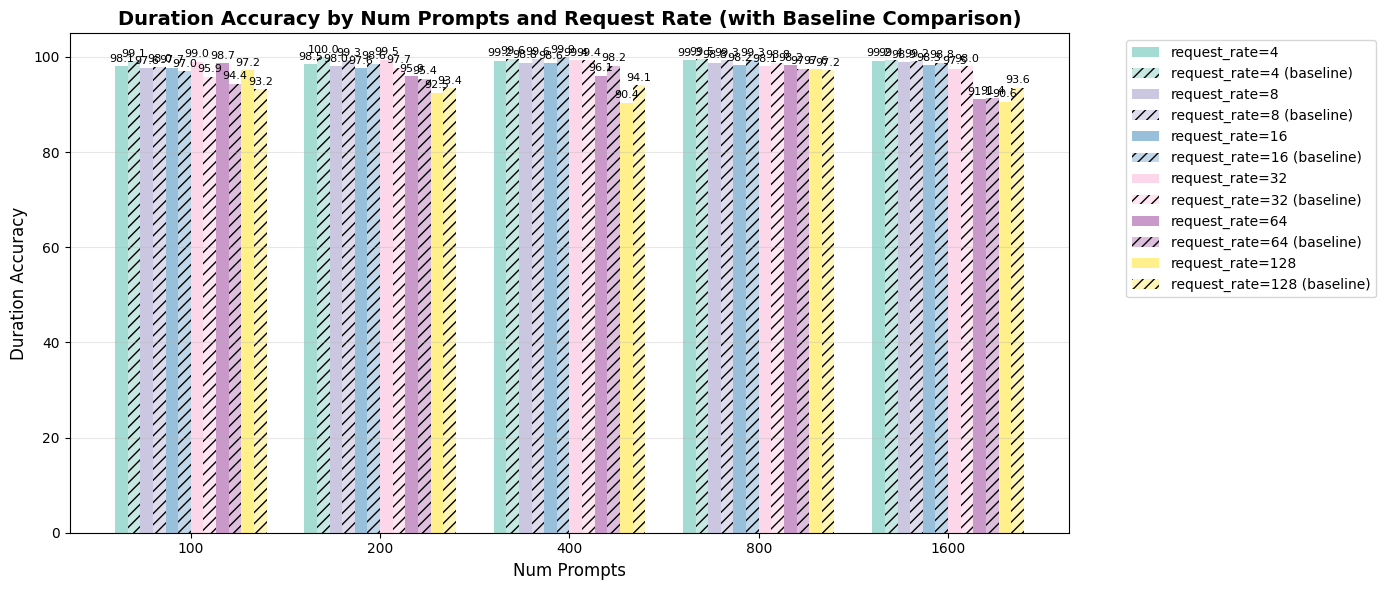

In [30]:
 # Calculate and plot
averaged_data = plot_all_metrics(plotting_data, sweep_configs, x_axis, y_axis, baseline_plotting_data=baseline_plotting_data)